PS3 - De Becker, Di, Gallese, Martiriggiano

In this report we will analyze the data given on the moodle that is assumed to represent different patents and the directed link from one citing another. We attempted to google query it (see code in sql section). However, after executing some analysis (drawing te graph and degree distribution) we came to the conclusion the data didn't seem to allign with the format that was expected, as it was very large and the degree distribution seemed odd. [maybe merge the code in the annex ]. We begin with a centrality analysis to identify key vs irrelevant players and conduct a clustering analysis to identify key segments of the patent pool

In [1]:
# Import needed packages 
import networkx as nx
import csv 
import random
import collections
import operator
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import networkx.algorithms.community

### Code in SQL

Hereafter the code used to queery the data from the Google Patent dataset, and in a separate file attached to the submission you can find also the result.

In [ ]:
#for Homework3 Data Science in Practice
####
#### DO NOT RUN THIS CELL
####
SELECT S.publication_number as origin, C.publication_number as citation 
FROM `patents-public-data.patents.publications` AS S, UNNEST(S.citation) as C
WHERE S.publication_date >= 20160101 and S.publication_date <= 20201231 and
      C.publication_number  IN 
      ( SELECT pubs.publication_number as pubsnum
        FROM `patents-public-data.patents.publications` AS pubs, UNNEST(pubs.cpc) as CPC
        WHERE pubs.publication_date >= 20160101 and pubs.publication_date <= 20161231 
        and CPC.code LIKE 'G06Q30/06%') 

### Initial Exploration

For the assignment it is decided to use the data provided on Moodle as we managed to queery the data from the Google database just today as a student in our group decided to use his credit card and we weren't sure if the data we collected were valid especially because the map of the graph was very dense.

First let's ask for some information regarding our directed graph which doesn't have any weights and let's visualize it using draw (G)

In [2]:
# Read the file and get some info on the nodes, edges, and average degree of our network

G=nx.read_edgelist('Network.txt')
nx.info(G)

DiG = nx.read_edgelist('Network.txt',create_using=nx.DiGraph())
nx.info(DiG)

'Name: \nType: DiGraph\nNumber of nodes: 4039\nNumber of edges: 88234\nAverage in degree:  21.8455\nAverage out degree:  21.8455'

# Analysis

#### Degree Distribution

Since the degree of a network is one of the most important features, let's give a look to what our network is like from this point of view

Text(0.5, 0, 'Degree')

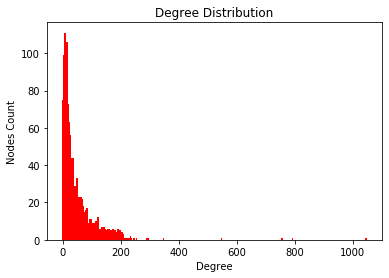

In [3]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # enumerating through the nodes to ask for degree and sorting them from biggest to smallest

degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt,width=5, color='r')

plt.title("Degree Distribution")
plt.ylabel("Nodes Count")
plt.xlabel("Degree")

It can be observed that most of the nodes have few links, but there are some players which gets to more than 1000 links. This is an important observation to identify players which are more important in the patent competition.

#### Centrality

In network analysis, centrality is the commonly used measure of "importance" of the node. We are going to apply different types of centrality to study the patents in the telecom industry. 

Note: We keep the assumption that the direction in the graph is from the new paterns to the cited ones. 

#### Find the central player
The central player should own the patent connecting as much as possible patents in the industry, thus, it should have high betweeness centrality 


C:\Users\YaoDI\AppData\Local\Continuum\anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


(-0.8044640990828702,
 0.9305119819697067,
 -1.085041671058083,
 0.7558558275903706)

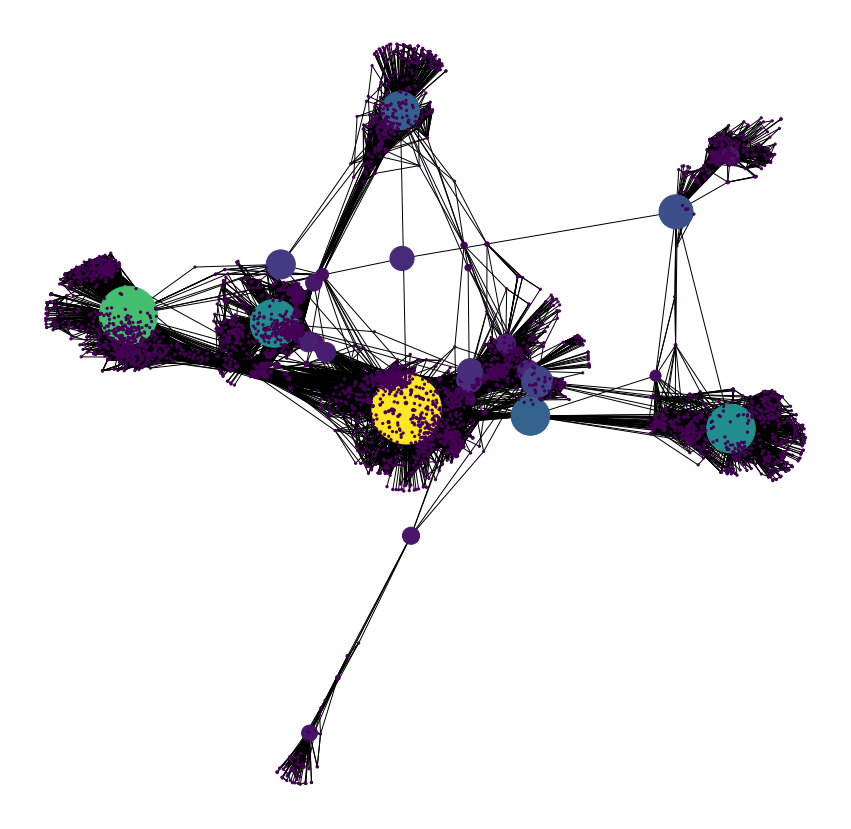

In [4]:
Position = nx.spring_layout(G)
Btw_centrality = nx.betweenness_centrality(G, normalized=True, endpoints=True)
node_color = [v * 10000 for v in Btw_centrality.values()]
node_size =  [v * 10000 for v in Btw_centrality.values()]
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, Position, with_labels = False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

#### Find the industry leader 
The industry leader should be the owner of the most cited patents, which has highest in degree centrality

(-0.8896044355630874,
 1.0156521660089493,
 -1.1754354864358902,
 0.8462496429681778)

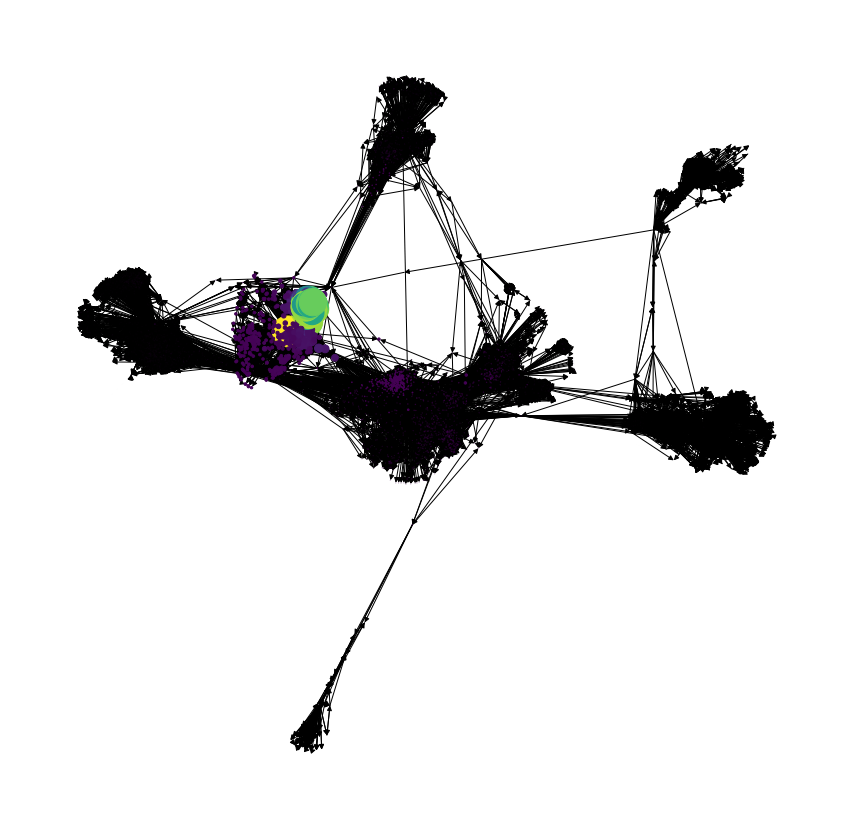

In [16]:
ID_centrality = nx.in_degree_centrality(DiG)
node_color = [10000 * v for v in ev_centrality .values()]
node_size =  [10000 * v for v in ev_centrality .values()]
plt.figure(figsize=(15, 15))
nx.draw_networkx(DiG, Position, with_labels = False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

#### Find the irrelevant actor
The irrelevant actor should has the lowest impact on the other paterns, therefore, it should have the lowest eigenvector centrality

(-0.8030426957523183,
 0.9292983467844366,
 -1.0839174574681092,
 0.7543868126302897)

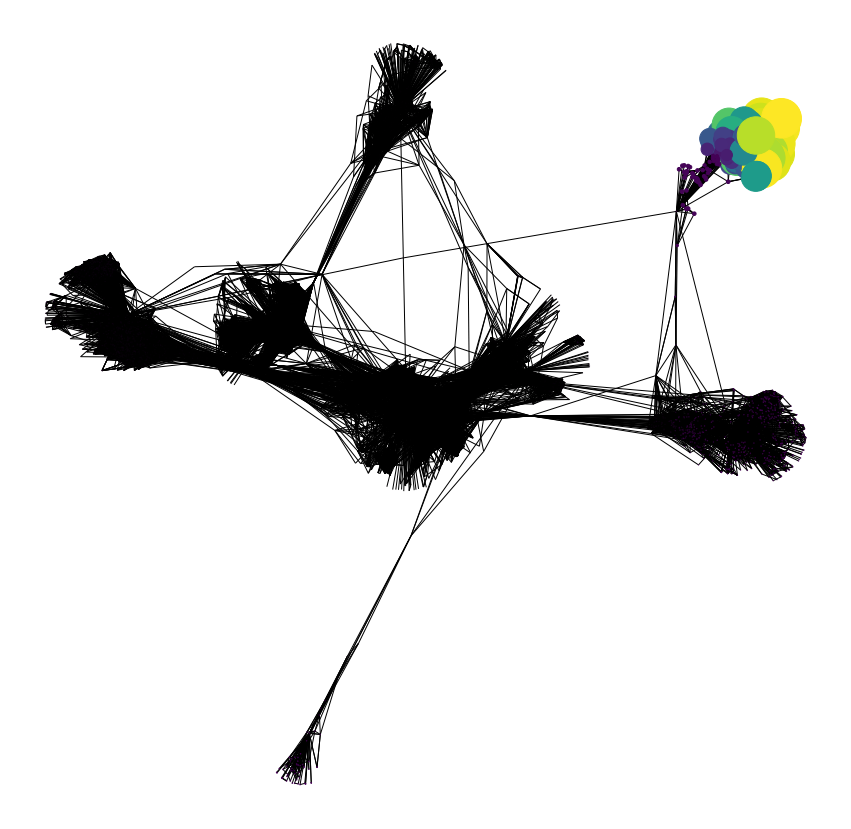

In [15]:
ev_centrality = nx.eigenvector_centrality(G)
node_color = [1e-10 / v for v in ev_centrality .values()]
node_size =  [1e-10 / v for v in ev_centrality .values()]
plt.figure(figsize=(15, 15))
nx.draw_networkx(G, Position, with_labels = False,
                 node_color=node_color,
                 node_size=node_size )
plt.axis('off')

In [ ]:
# define a function to calculate centrality 
def calculate_centrality(G):
    degrees = [val for (node, val) in G.degree()] #only the values
    nodes = [node for (node, val) in G.degree()] #only the node

    cen = [x for _,x in sorted(zip(degrees,nodes), reverse=True)]
    return cen

### Page Rank

The pagerank algorithm is invented by Google to rank the web pages in its research algorithm. It encodes the web graph through an incidence matrix in which every element is equal to 1 if there is a link between the two nodes, and 0 otherwise.

This algorithm uses a Markov chain that mimics a virtual random surfer in which the surfer moves from node i to j with probability p*Aij/ni, where p is a factor selected by the coder and ni is the number of links out of node i, and to a random node with probability (1-p)/ni.

Running this algorithm, a rank is built where the PageRank of each page i represents the stationary probability of being in node i. Therefore, the higher the rank of i, the higher its importance.

Note: Google usually sets p=85% to make the rate of convergence fast enough, therefore, there same factor will be used.

In [8]:
# Calculating the page rank

Rank = nx.pagerank(G, alpha=0.85)
Rank_df = pd.DataFrame.from_dict(Rank, orient = "index", columns = ["Rank"])
Rank_df.sort_values(by = ["Rank"], ascending = False).head(20)

,Rank
3437,0.007615
107,0.006936
1684,0.006367
0,0.006290
1912,0.003877
348,0.002348
686,0.002219
3980,0.002170
414,0.001800
698,0.001317


It can be observed that the node 3437 is the one with the highest ranking, and that it was also the 4th in the chart based on centrality. Moreover, node 107, which was the 1st in the chart based on the centrality, is the second with the highest rank.

We can conclude that these two nodes are most probably very important in this network.

### Cluster Analysis

Centrality is an important measure and would alow us to idenitfy key patents fom which to get inspired, 
since they have the most links from other. However it is important to not that there are different 'types' of patents and perhaps not all patents are fit for 
the same application and it may be wiser to look at a less central player but more central in a given group. 
For this reason it is useful to conduct a clustering process where we identify these groups, or as it is said in data science "communities".In our case our boss "wants to patent the data processing methods" developped by our company, after finding different communities it would be useful to look at central players in each one to see which ones relate the most to the type of patent we want to file.

In [69]:
from community import community_louvain
clusters = community_louvain.best_partition(G) 
n_cluster = max(clusters.values())
print("We can cluster the nodes into", n_cluster, "communities.")

We can cluster the nodes into 15 communities.


In [70]:
import itertools
nodes_in_cluster =[]
for k, v in itertools.groupby(sorted(clusters.values())):
    print("Cluster #", k, " contains ", len(list(v)))


Cluster # 0  contains  350
Cluster # 1  contains  430
Cluster # 2  contains  435
Cluster # 3  contains  423
Cluster # 4  contains  535
Cluster # 5  contains  325
Cluster # 6  contains  128
Cluster # 7  contains  548
Cluster # 8  contains  73
Cluster # 9  contains  237
Cluster # 10  contains  25
Cluster # 11  contains  60
Cluster # 12  contains  206
Cluster # 13  contains  226
Cluster # 14  contains  19
Cluster # 15  contains  19


(-0.5965968466641168, 0.6295288897396785, -1.08248005196252, 0.6717518953959)

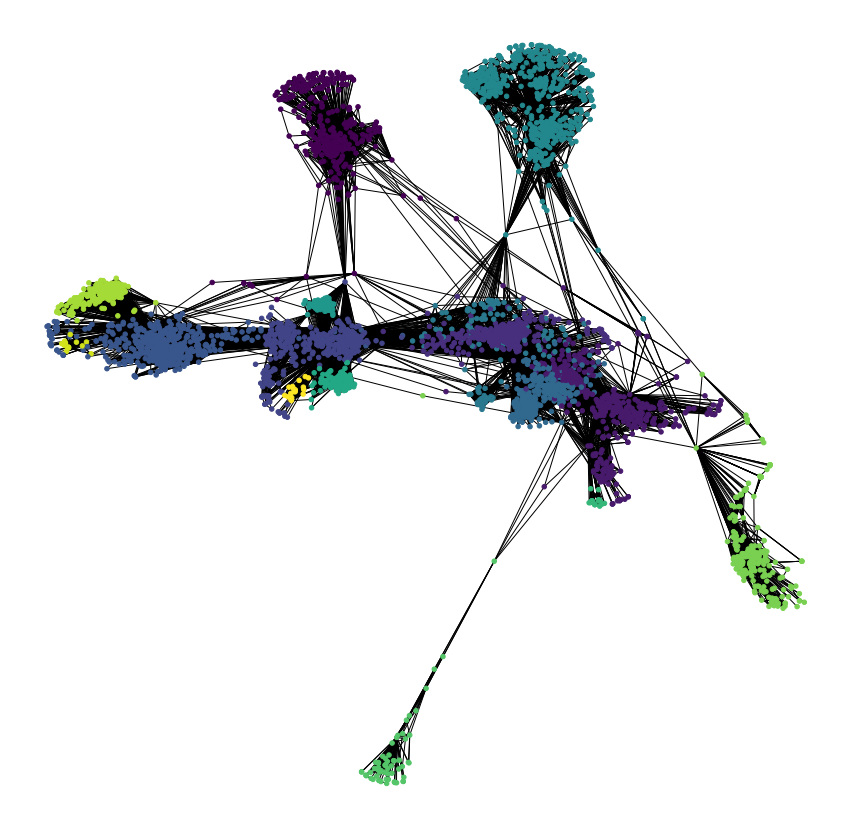

In [76]:
#Visualize the cluster
import random
colors = []
for k, v in clusters.items():
    colors.append(20000*v)


plt.figure(figsize=(15, 15))
nx.draw_networkx(G, pos=pos, with_labels=False,
                 node_color=colors,
                node_size = 20)
plt.axis('off')

In [74]:
for i in range(n_cluster):
    nodes_sub = [k for k,v in clusters.items() if v == i];
    G_sub = G.subgraph(nodes_sub)
    n_nodes_sub = len(nodes_sub)
    
    
    centrality = calculate_centrality(G)

    #find the most connected nodes
    most_con_nodes = G_sub.degree(centrality)
    
    print("Most important nodes in cluster",i)
    for ii in range(3):
        print(f"Position #{ii+1}: node {list(most_con_nodes)[ii][0]} with degree {list(most_con_nodes)[ii][1]}")


Most connected nodes in cluster 0
Position #1: node 0 with degree 342
Position #2: node 56 with degree 77
Position #3: node 67 with degree 75
Most connected nodes in cluster 1
Position #1: node 483 with degree 155
Position #2: node 348 with degree 227
Position #3: node 414 with degree 131
Most connected nodes in cluster 2
Position #1: node 107 with degree 434
Position #2: node 1888 with degree 253
Position #3: node 1800 with degree 240
Most connected nodes in cluster 3
Position #1: node 1912 with degree 422
Position #2: node 1941 with degree 116
Position #3: node 2047 with degree 201
Most connected nodes in cluster 4
Position #1: node 1684 with degree 533
Position #2: node 3101 with degree 122
Position #3: node 3291 with degree 119
Most connected nodes in cluster 5
Position #1: node 917 with degree 116
Position #2: node 896 with degree 122
Position #3: node 1277 with degree 120
Most connected nodes in cluster 6
Position #1: node 1687 with degree 37
Position #2: node 1837 with degree 36

As seen we identified there were 15 communities - meaning 15 groups which may have common similarities in terms of patent content or application. A a result we should identify which community fits best our patent description and look for the key player in that/those groups.